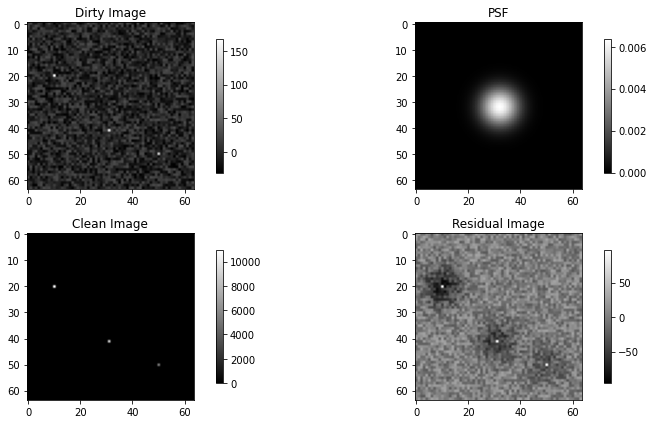

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def create_dirty_image(size, sources):
    """Create a dirty image with point sources and noise."""
    noise_rms = 60
    
    image = noise_rms*(np.random.random([size,size])-0.5)
    for (x, y, intensity) in sources:
        image[y, x] += intensity
    return image

def create_psf(size, sigma):
    """Create a Gaussian PSF."""
    psf = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            psf[i, j] = np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))
    psf /= np.sum(psf)  # Normalize PSF
    return psf


def clean(dirty_image, psf, threshold, max_iter,gain):
    """Perform the CLEAN algorithm."""
    # Step 1: initialize clean image and residual image
    
    clean_image = np.zeros_like(dirty_image)
    residual = np.copy(dirty_image)
    
    psf_size = psf.shape[0]
    psf_center = psf_size // 2
    
    # iterate through number of iterations
    for i in range(max_iter):
        # Step 2: strength and position of peak in residual image
        
        # Get the coordinates of the peak 
        peak_coords = np.unravel_index(np.argmax((residual)), residual.shape)
        #print(peak_coords)
        
        # Find the peak in the residual image
        peak_value = residual[peak_coords]
        #print(peak_value)
        
        # Step 3: Repeat from Step 2 on, unless residual image< threshold
        # Stopping criteria if residual image is below threshold
        if (peak_value) < threshold:
            print("Iteration:",i)
            break
        # Extract the PSF centered on the peak
        y_start = max(0, peak_coords[0] - psf_center)
        y_end = min(dirty_image.shape[0], peak_coords[0] + psf_center + 1)
        x_start = max(0, peak_coords[1] - psf_center)
        x_end = min(dirty_image.shape[1], peak_coords[1] + psf_center + 1)

        psf_slice = psf[psf_center - (peak_coords[0] - y_start):psf_center + (y_end - peak_coords[0]),
                        psf_center - (peak_coords[1] - x_start):psf_center + (x_end - peak_coords[1])]

        # Ensure the PSF slice and the residual region have the same shape
        psf_slice = np.pad(psf_slice, ((0, max(0, y_end - y_start - psf_slice.shape[0])),
                                        (0, max(0, x_end - x_start - psf_slice.shape[1]))), mode='constant')

        # Subtract the scaled PSF from the residual
        residual[y_start:y_end, x_start:x_end] -= gain*peak_value*psf_slice

        # Step 5: Record peak position and magnitude subtracted in clean image
        # Add the peak to the clean image
        clean_image[peak_coords] += gain*peak_value
        
        
            
          
    return clean_image, residual

# Parameters
size = 64  # Size of the image
sources = [(31, 41, 170.0),(50,50,130.0),(10,20, 150.0)]  # (x, y, intensity)
sigma = 5.0  # Width of the PSF
threshold = 0.01  # Threshold for CLEAN
max_iter = 1000 # Maximum iterations
gain=0.2
# Create the dirty image and PSF
dirty_image = create_dirty_image(size, sources)
psf = create_psf(size, sigma)

# Perform CLEAN
clean_image, residual  = clean(dirty_image, psf, threshold, max_iter,gain)



# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.title('Dirty Image')
plt.imshow(dirty_image, cmap='gray')
plt.colorbar(shrink=0.8)

plt.subplot(222)
plt.title('PSF')
plt.imshow(psf, cmap='gray')
plt.colorbar(shrink=0.8)

plt.subplot(223)
plt.title('Clean Image')
plt.imshow(clean_image, cmap='gray')
plt.colorbar(shrink=0.8)

plt.subplot(224)
plt.title('Residual Image')
plt.imshow(residual, cmap='gray')
plt.colorbar(shrink=0.8)

plt.tight_layout()
plt.savefig('clean_algorithm.png',dpi=500,bbox_inches='tight')
plt.show()